In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import interactive
import matplotlib.pyplot as plt
import numpy as np

from sklearn import decomposition
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, PolynomialFeatures)
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

from random import shuffle
from mpl_toolkits.mplot3d import Axes3D


C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Setup formatting of output

def myformat(x):
    if isinstance(x, str):
        return [x]
    else:
        return '{:.3f}'.format(x)

# This is a string for visual separation of different sections of output.
seperator = '\n' + ('-'*80) + '\n'

In [3]:
# Get pre-computed ratios data and training data
ratios_df = pd.read_csv('ratiostest.csv')
train_df = pd.read_csv('Data/train.csv')

# Set indices for training and ratios data. Then combine. 
# Result printed to make sure isoperimetric ratios properly line up.
train_df = train_df.set_index('id')

ratios_df = ratios_df.set_index('id')
print(seperator, 'Ratios Data Set Info')
print(ratios_df.info())
print(ratios_df[:6].applymap(myformat))

train_df = pd.concat([train_df, ratios_df], axis = 1, join_axes = [train_df.index])
print(seperator, 'After adding ratios column, training data is\n')
train_df[:4].applymap(myformat).head()


--------------------------------------------------------------------------------
 Ratios Data Set Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584 entries, 1 to 1584
Data columns (total 1 columns):
isopratio    1584 non-null float64
dtypes: float64(1)
memory usage: 24.8 KB
None
   isopratio
id          
1     10.619
2     12.229
3     10.981
4     10.133
5     11.181
6     11.584

--------------------------------------------------------------------------------
 After adding ratios column, training data is



,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,isopratio
id,,,,,,,,,,,,,,,,,,,,,
1,[Acer_Opalus],0.008,0.023,0.023,0.004,0.012,0.010,0.027,0.000,0.002,...,0.000,0.003,0.003,0.035,0.000,0.000,0.005,0.000,0.025,10.619
2,[Pterocarya_Stenoptera],0.006,0.000,0.031,0.016,0.025,0.002,0.020,0.000,0.000,...,0.000,0.000,0.001,0.023,0.000,0.000,0.001,0.039,0.022,12.229
3,[Quercus_Hartwissiana],0.006,0.010,0.020,0.008,0.004,0.006,0.068,0.000,0.000,...,0.000,0.006,0.001,0.008,0.000,0.000,0.000,0.021,0.003,10.981
5,[Tilia_Tomentosa],0.000,0.004,0.023,0.006,0.021,0.020,0.023,0.000,0.014,...,0.001,0.000,0.000,0.021,0.000,0.000,0.018,0.000,0.048,11.181


In [4]:
# Now we need to encode the species category and do a Stratified Shuffle Split for cross validation.

le = LabelEncoder().fit(train_df.species)
train_df['species'] = le.transform(train_df.species)

# Now seperate data for cross validation

sss = StratifiedShuffleSplit(train_df['species'].values, 10, test_size = 0.3, random_state = 17)
for train_i, test_i in sss:
    train_index = train_i
    test_index = test_i

test_df = train_df.iloc[test_index]
train_df = train_df.iloc[train_index]
y_train = train_df['species'].values
y_test = test_df['species'].values

print(seperator, 'After cross validation separation, description of the training data species count = \n', train_df[['species']].applymap(myformat).describe())
print('After cross validation separation, description of the test data = \n', test_df[['species']].applymap(myformat).describe())


--------------------------------------------------------------------------------
 After cross validation separation, description of the training data species count = 
        species
count      693
unique      99
top     94.000
freq         7
After cross validation separation, description of the test data = 
        species
count      297
unique      99
top     45.000
freq         3



--------------------------------------------------------------------------------
 After grouping by species and reordering, traingroups = 
         isopratio
species          
25          8.776
21          8.820
34          8.836
23          8.962
Order of species is
 [25 21 34 23 31 39 97 62 52 40]

--------------------------------------------------------------------------------
 Training Data indices after attaching ordering
 Int64Index([1310, 1123, 879, 952], dtype='int64', name='id')


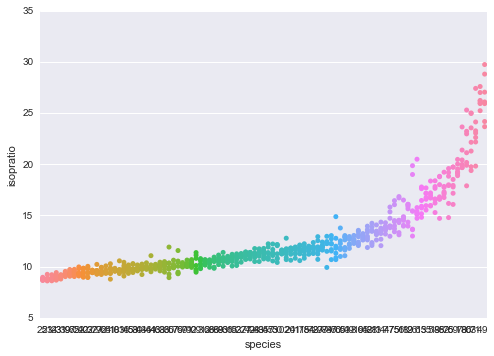

In [5]:
# To get a look at how the isoperimetric ratios vary by species, we order the species 
# by increasing mean isoperimetric ratio. Then we graph ratio vs species.

traingroups = train_df[['species', 'isopratio']].groupby('species').mean()
traingroups = traingroups.sort_values(by = 'isopratio', ascending = 1)
print(seperator, 'After grouping by species and reordering, traingroups = \n', traingroups.applymap(myformat)[:4])
speciesorder = traingroups.index.values
print('Order of species is\n', speciesorder[:10])

train_df['species'] = train_df['species'].astype('category')
train_df['species'] = train_df['species'].cat.set_categories(speciesorder, ordered = True)

print(seperator, 'Training Data indices after attaching ordering\n', train_df.applymap(myformat).index[:4])

# Plot species on x-axis and ratios on y-axis. Categories appear in the order we specified above.
# Therefore, they appear in order of increasing mean ratio.

ax = sns.stripplot(x = 'species', y = 'isopratio', data = train_df)
plt.show()

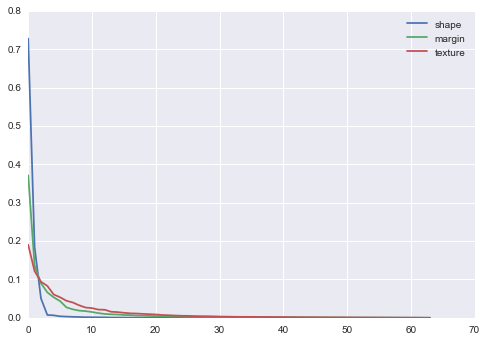

In [6]:
# Now we will do PCA for the texture, shape, and margin features. We won't combine these 
# categories of features as it isn't clear how their length scales should be compared. Before we decide 
# on the number of components to keep, we need to keep analyze the variance ratios which we keep inside
# a dictionary.

variance_ratios = {}

for name in ['texture', 'shape', 'margin']:
    pca = decomposition.PCA()
    collist =[name + str(i + 1) for i in range(64)]
    pca.fit(train_df[collist])
    variance_ratios[name] = pca.explained_variance_ratio_

# Graph variance ratios of PCA for each attribute
for series in variance_ratios.values():
    plt.plot(series)
plt.legend(variance_ratios.keys(), loc = 'upper right')
plt.show()

In [7]:
# Using the graph of the variances, now decide which number of components of PCA to keep. Keep in a dictionary.

ncomponents = {}
ncomponents['texture'] = 4
ncomponents['shape'] = 2
ncomponents['margin'] = 6

# Now we use SciKit Pipeline and Function Transformer to allow feature selection and
# separate PCA on each feature, using the number of components we have decided to keep.
# For now, we keep track of pipelinekeys for each feater. Later we may put everything 
# into a single transformer using Pipeline and Feature Union.
    
def getColumns(name_, dfvalues):
    start = train_df.columns.get_loc(name_ + str(1))
    end = 1 + train_df.columns.get_loc(name_ + str(64))
    return dfvalues[:, start:end]

# Create dictionary of functions for getting columns of each feature.
# Note the use of double lambdas to properly scope the use of name.

colFunc = {}
for name in ['texture', 'shape', 'margin']:
    colFunc[name] = (lambda n: lambda X : getColumns(n, X))(name)
    
getisoploc = lambda : train_df.columns.get_loc("isopratio")
colFunc['isopratio'] = lambda df : np.array([df[:, getisoploc()]]).T

pipelinekeys = {}
for name in ['texture', 'shape', 'margin', 'isopratio']:
    key = ('cols_' + name, FunctionTransformer(colFunc[name]))
    pipelinekeys[name] = [key]
           
for name in ['texture', 'shape', 'margin']:
    key = ('pca_' + name, decomposition.PCA(n_components = ncomponents[name]))
    pipelinekeys[name].append(key)


In [8]:
# Transform the training data to continue building our model. Double check that the 
# transformed data has the right shape. Also double check contents of newData, especially
# to make sure there isn't any scoping issues in our Function Transformer that cause all
# of the features to be pulled from the same data.

newData = {}

for name in ['texture', 'shape', 'margin', 'isopratio']:
    transformer = Pipeline(pipelinekeys[name])
    newData[name] = transformer.fit_transform(train_df.values)
    height, width = newData[name].shape
    print("For " + name + ", shape = " + str(newData[name].shape))
    print("newData[" + name +"][:4] = ")
    print(newData[name][:4])

For texture, shape = (693, 4)
newData[texture][:4] = 
[[ 0.00781469 -0.1170446  -0.00654746  0.04130901]
 [ 0.16745287  0.09626075 -0.05504714 -0.05830012]
 [ 0.04675485 -0.11217717  0.05241998  0.01912689]
 [ 0.04292097 -0.04847828 -0.01422558 -0.07668422]]
For shape, shape = (693, 2)
newData[shape][:4] = 
[[-0.00174536 -0.00101563]
 [ 0.00063477  0.00099526]
 [-0.00023779  0.00115718]
 [-0.00179387 -0.00022165]]
For margin, shape = (693, 6)
newData[margin][:4] = 
[[-0.02805482  0.01365204 -0.03869438  0.01482869  0.00420742  0.00210274]
 [ 0.11349612 -0.06824881 -0.0066569   0.01362625 -0.03301561 -0.04241847]
 [ 0.01308141 -0.00328548 -0.03609774 -0.04946091 -0.00867878 -0.00512571]
 [ 0.02569113  0.01639262  0.00980169 -0.03221029 -0.02996317  0.01660931]]
For isopratio, shape = (693, 1)
newData[isopratio][:4] = 
[[ 12.05115292]
 [  9.58376298]
 [ 10.48054167]
 [ 10.00662712]]


In [9]:
# Add scalers to pipelinekeys. Scalers help with normalization for comparison.
# For each feature, we only fit our scaler using only the first component. We don't
# want to independently normalize the other components as they represent smaller
# variations in the feature.

def scaleUsingFirstFeature(X):
    scaler = MinMaxScaler()
    scaler.fit(X[:,0].reshape(-1,1))
    return scaler.transform(X)
    
for name in ['texture', 'shape', 'margin', 'isopratio']:
    transformer = FunctionTransformer(scaleUsingFirstFeature)
    key = ('scaler_' + name, transformer)
    pipelinekeys[name].append(key)
    newData[name] = transformer.transform(newData[name])

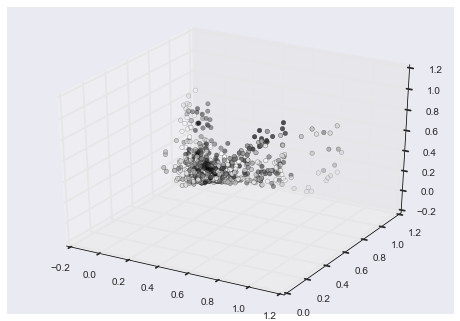

In [10]:
# Make 3d scatterplot
colordict = {}
for i in range(len(speciesorder)):
    colordict[speciesorder[i]] = i

varstoplot = ['texture1', 'texture2', 'texture3']
plotcolors = train_df['species'].apply(lambda x: colordict[x]) 
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection = '3d' )
ax2.scatter(newData['texture'][:,0], newData['texture'][:,1], newData['texture'][:,2], c = plotcolors)

plt.show()

In [11]:
# Double Check the Contents of the Pipeline Keys.

pipelinekeys

{'isopratio': [('cols_isopratio', FunctionTransformer(accept_sparse=False,
             func=<function <lambda> at 0x000002665E11D400>, inv_kw_args=None,
             inverse_func=None, kw_args=None, pass_y=False, validate=True)),
  ('scaler_isopratio', FunctionTransformer(accept_sparse=False,
             func=<function scaleUsingFirstFeature at 0x000002665E1967B8>,
             inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
             validate=True))],
 'margin': [('cols_margin', FunctionTransformer(accept_sparse=False,
             func=<function <lambda>.<locals>.<lambda> at 0x000002665E11D1E0>,
             inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
             validate=True)),
  ('pca_margin',
   PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('scaler_margin', FunctionTransformer(accept_sparse=False,
             func=<function scaleUsingFirstFeature at 0x000002

In [12]:
# Set up training/testing data for the cases of with and without isoperimetric ratios. To be used in estimator.

componentcols = []
for name in ['texture', 'shape', 'margin']:
    collist = [name + str(i+1) for i in range(ncomponents[name])]
    componentcols.extend(collist)
    
X_train_with = train_df[componentcols + ['isopratio']].values
X_test_with = test_df[componentcols + ['isopratio']].values
X_train_without = train_df[componentcols].values
X_test_without = test_df[componentcols].values

# Set up preprocessing with and without Isoperimetric Ratios. Use SciKit Feature Union.

transformerkeys = []
for name in ['texture', 'shape', 'margin']:
    key = (name, Pipeline(pipelinekeys[name]))
    transformerkeys.append(key)
    
combined = {}

isopkey = ('isopratio', Pipeline(pipelinekeys['isopratio']))
combined['with'] = FeatureUnion(transformerkeys + [isopkey])
combined['without'] = FeatureUnion(transformerkeys)


In [13]:
# Do K Nearest Neighbors for the cases of with and without isoperimetric ratios.

neighborsrange = range(12)
acc = {'with' : [], 'without' : []}
logloss = {'with' : [], 'without' : []}

for kneighbors in neighborsrange:
    knn = KNeighborsClassifier(kneighbors + 1)
    
    for name in ['with', 'without']:
    
        # Make the K Nearest Neighbor classifier using right pipeline
        
        clfkeys = [("combined", combined[name]), ("knn", knn)]
        clf = Pipeline( clfkeys )
        clf.fit(train_df.values, y_train)
        test_predictions = clf.predict(test_df.values)
        prob_predictions = clf.predict_proba(test_df.values)
    
        # Accuracy and LogLoss

        acc[name].append(accuracy_score(y_test, test_predictions))
        logloss[name].append(log_loss(y_test, prob_predictions))
    

kvalues = [i + 1 for i in neighborsrange]
results = [kvalues, acc['with'], logloss['with'], acc['without'], logloss['without']]
results = np.array(results).T
collist = ['k', 'AccWith', 'LogLossWith', 'AccWithout', 'LogLossWithout']
results_df = pd.DataFrame(results, columns = collist)
results_df = results_df.set_index('k')

results_df    

,AccWith,LogLossWith,AccWithout,LogLossWithout
k,,,,
1.0,0.898990,3.488765,0.888889,3.837642
2.0,0.878788,1.854073,0.841751,2.337912
3.0,0.885522,1.343915,0.865320,1.368839
4.0,0.872054,1.051296,0.851852,1.085685
5.0,0.865320,0.660641,0.841751,0.909323
6.0,0.855219,0.719750,0.838384,0.741098
7.0,0.841751,0.788428,0.841751,0.815347
8.0,0.831650,0.873107,0.828283,0.886263
9.0,0.838384,0.959750,0.818182,0.863862
